# Can Emoticons Be Use To Predict Sentiment
## Keenen Cates
### Bayesian Benchmark Model

# Setup

We will first load all of the preprocessed data, and split the validation set off. Also, we will make a list of skin tone modifiers for emoticons the obfuscate the prediction (i.e. a skin tone modifier can accompany many emoticons to modify their skin tone). A deeper look will need to be done into how to deal with multi-colored hearts.

In [1]:
import numpy as np
import pandas as pd
from requests import get
from os import path
from io import BytesIO
from zipfile import ZipFile
from emoji_list import all_emoji
from time import strftime
from urllib.request import urlopen 
from collections import Counter
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import helper
import math

#Load comments, targets, and dictionaries for embeddings, and holdout validation data
content, targets, emoji_to_int, int_to_emoji, vocab_to_int, int_to_vocab, token_lookup = helper.load_preprocess()
X, Y, VAL_X, VAL_Y = helper.peel_validation(content, targets)
skin_tones = helper.skin_tone_emojis()

# Building the Model
The first step is to build our model of prior probabilities for each class and probabilities of each class relative to a given word. We could likely extend our model by changing the level at which we are modelling (i.e. N-Gram models).

In [2]:
def generate_naive_bayes_model(model_x, model_y):
    """ Takes a corpus of embedded comments and labels 
        and returns Naive Bayes Probabilities
    :type model_x: List[List[Int]]
    :type model_y: List[List[Int]]
    :rtype       : Int, Dict, Dict, Dict, Dict
    """
    n_texts = 0
    class_dict = {emoji_to_int[k]:Counter() for k in all_emoji if k in emoji_to_int}
    n_texts_class = {emoji_to_int[k]:1 for k in all_emoji if k in emoji_to_int}
    
    for i in range(len(model_x)):
        n_texts += 1
        for each in model_y[i]:
            class_dict[each].update(model_x[i])
            n_texts_class[each] += 1

    rel_freq_class_dict = {emoji_to_int[k]:dict() for k in all_emoji if k in emoji_to_int}
    
    for class_key, counts in class_dict.items():
        total_words = sum([val for _, val in class_dict[class_key].items()])
        for word in counts:
            rel_freq_class_dict[class_key][word] = class_dict[class_key][word] / total_words 

    prior_prob_class = {emoji_to_int[k]:n_texts_class[emoji_to_int[k]] / n_texts  for k in all_emoji if k in emoji_to_int}
    
    return n_texts, class_dict, n_texts_class, rel_freq_class_dict, prior_prob_class

In [3]:
n_texts, class_dict, n_texts_class, rel_freq_class_dict, prior_prob_class = generate_naive_bayes_model(X, Y)

def get_rel_freq(class_key, word):
    """Takes a class and a word and return prob
       of the class given the word.
    :type class_key: Int
    :type word     : Int
    :rtype         : Float
    """
    if word in rel_freq_class_dict[class_key]:
        return rel_freq_class_dict[class_key][word]
    else:
        return .000000000001

def compute_prob(class_key, text, scale = 1.0):
    """Computes the probability of a text having a given emoji
    :type class_key: Int
    :type text     : List[Int]
    :type scale    : Float
    :rtype         : Float
    """
    prod_freqs = np.prod([get_rel_freq(class_key, word) for word in text])
    prior = prior_prob_class[class_key]
    return prod_freqs * (prior * scale)

def create_probs(text, scale = 1.0):
    """Computes the probability of all classes for a given text
    :type text     : List[Int]
    :type scale    : Float
    :rtype         : Float
    """
    return {emoji_to_int[k]:compute_prob(emoji_to_int[k], text, scale) for k in all_emoji if k in emoji_to_int}

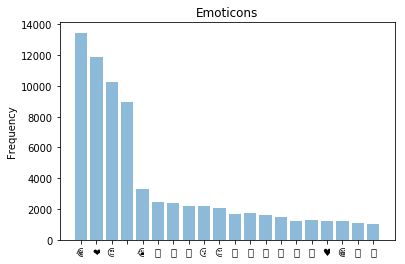

In [9]:
hist = [(int_to_emoji[k], v) for k, v in n_texts_class.items()][:20]
emoticons = []
counts = []
for k, v in hist:
    emoticons.append(k)
    counts.append(v)
y_pos = np.arange(len(emoticons))

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, emoticons)
plt.ylabel('Frequency')
plt.title('Emoticons')
 
plt.show()

# Making Predictions
We will make predictions make selecting the top k most likely classes. This is because there is some ambiguity to emoticons, i.e. there are multiple types of hearts and smiley faces with hearts. That means that multiple classes could be appropriate for a given text.

In [ ]:
def top_k_predictions(text, k, preprocess=False, scale = 1.0):
    """Computes the top k most probable classes
    :type text      : List[Int]
    :type k         : Int
    :type preprocess: Boolean
    :type scale     : Float
    :rtype          : List[Int]
    """
    if preprocess:
        text = helper.tokenize_and_embed(text, token_lookup, vocab_to_int)
    probs = create_probs(text, scale)
    probs = {k:v for k, v in probs.items()}
    probs = probs.items()
    sorted_probs = sorted(probs, key=lambda x: x[1], reverse=True)
    
    res = []
    idx = 0
    while len(res) < k:
        #We want to ignore the skin tone modifiers
        if int_to_emoji[sorted_probs[idx][0]] not in skin_tones:
            res.append(sorted_probs[idx][0])
        idx += 1
    return res

def dummy_top_k_predict(x, k):
    """Predicts the top k most frequent classes
    :type x: List[Int]
    :type k: Int
    :rtype : List[Int]
    """
    classes = prior_prob_class.items()
    classes = sorted(classes, key = lambda x: x[1], reverse = True)
    return [classes[i][0] for i in range(0, k)]

def print_nth_prediction(text_n, scale=1.0):
    """Prints a nicely formatted chart for comparing results
    :type text      : List[Int]
    :type scale     : Float
    """
    print('Comment     :', helper.get_nth_text(content, int_to_vocab, text_n))
    print('Emoticons   :', helper.get_nth_label(targets, int_to_emoji, text_n))
    print('Top 5 Preds :', ' '.join(int_to_emoji[each] for each in top_k_predictions(content[text_n], 5, scale = scale)))
    print('Dummy Pred  :', ' '.join(int_to_emoji[each] for each in dummy_top_k_predict(content[text_n], 5)))

# Examples
Here are some examples of the Models Prediction!

In [ ]:
for i in range(0, 100, 5):
    print_nth_prediction(i)
    print('-' * 50)

# Validation

Finally we test our model! It appears that the model is having some problems generalizing. I am inclined to think the N-gram models could help us improve our generality. 

In [ ]:
print('Bayesian Training Accuracy :', helper.top_k_categorical_accuracy(X, Y, top_k_predictions))

In [ ]:
print('Dummy Training Accuracy    :', helper.top_k_categorical_accuracy(X, Y, dummy_top_k_predict))

In [ ]:
print('Bayesian Validation Accuracy :', helper.top_k_categorical_accuracy(VAL_X, VAL_Y, top_k_predictions))
print('Dummy Validation Accuracy    :', helper.top_k_categorical_accuracy(VAL_X, VAL_Y, dummy_top_k_predict))